# NLP with BERT

In [2]:
!pip install -q -U "tensorflow-text==2.8.*"

     |████████████████████████████████| 4.9 MB 35.3 MB/s 


In [3]:
!pip install -q tf-models-official==2.7.0

     |████████████████████████████████| 1.8 MB 31.7 MB/s 
     |████████████████████████████████| 1.3 MB 48.8 MB/s 
     |████████████████████████████████| 116 kB 76.1 MB/s 
     |████████████████████████████████| 596 kB 69.3 MB/s 
     |████████████████████████████████| 99 kB 11.5 MB/s 
     |████████████████████████████████| 43 kB 2.5 MB/s 
     |████████████████████████████████| 1.1 MB 44.1 MB/s 
     |████████████████████████████████| 238 kB 53.7 MB/s 
     |████████████████████████████████| 352 kB 23.5 MB/s 


In [4]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

In [5]:
tfhub_handle_preprocess='https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
tfhub_handle_encoder='https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'

In [6]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

84140032/84125825 [==============================] - 9s 0us/step


In [7]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [8]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

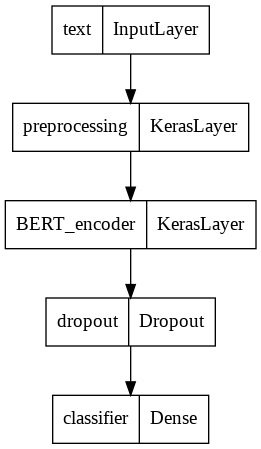

In [9]:
classifier_model = build_classifier_model()
tf.keras.utils.plot_model(classifier_model)

In [10]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [11]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [12]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [13]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
625/625 [==============================] - 167s 251ms/step - loss: 0.4787 - binary_accuracy: 0.7469 - val_loss: 0.3704 - val_binary_accuracy: 0.8340
Epoch 2/5
625/625 [==============================] - 156s 249ms/step - loss: 0.3297 - binary_accuracy: 0.8525 - val_loss: 0.3861 - val_binary_accuracy: 0.8276
Epoch 3/5
625/625 [==============================] - 155s 249ms/step - loss: 0.2475 - binary_accuracy: 0.8982 - val_loss: 0.3808 - val_binary_accuracy: 0.8502
Epoch 4/5
625/625 [==============================] - 155s 249ms/step - loss: 0.1908 - binary_accuracy: 0.9257 - val_loss: 0.4279 - val_binary_accuracy: 0.8542
Epoch 5/5
625/625 [==============================] - 156s 249ms/step - loss: 0.1526 - binary_accuracy: 0.9417 - val_loss: 0.4591 - val_binary_accuracy: 0.8558


In [14]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 87s 111ms/step - loss: 0.4537 - binary_accuracy: 0.8554
Loss: 0.45370641350746155
Accuracy: 0.855400025844574


In [17]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [18]:
classifier_model.save('my_model')

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


In [19]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the model in memory:
input: this is such an amazing movie! : score: 0.999575
input: The movie was great!           : score: 0.997509
input: The movie was meh.             : score: 0.970771
input: The movie was okish.           : score: 0.149582
input: The movie was terrible...      : score: 0.002461

